## K-Nearest Neighbors (KNN)
This section handles data preprocessing, model training using GridSearchCV, and evaluation of the KNN classifier.

## Importing Libaries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from joblib import dump

## 📂 1. Load and Preview Dataset

In [2]:
import csv
file_path = "FinalApartments_data.csv"  

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("EnhancedKNN")

# Load dataset
def load_data(file_path):
    data = pd.read_csv(file_path, low_memory=False)
    logger.info("CSV loaded successfully.")
    return data

## Pre-Processing 


In [3]:
def preprocess_data(data):
    numeric_columns = ['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude', 'longitude']
    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce').astype(np.float32)

    data = data.dropna(subset=['price']).copy()
    bins = [0, data['price'].quantile(0.33), data['price'].quantile(0.66), float('inf')]
    labels = ['Low', 'Medium', 'High']
    data['price_category'] = pd.cut(data['price'], bins=bins, labels=labels)

    logger.info(f"Price category distribution:\n{data['price_category'].value_counts()}")

    numeric_features = ['bedrooms', 'bathrooms', 'square_feet', 'latitude', 'longitude']
    categorical_features = ['cityname', 'state', 'pets_allowed']
    X = data[numeric_features + categorical_features]
    y = data['price_category']
    return X, y, numeric_features, categorical_features, labels

## Evalution Of Matrix 

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, labels):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)
    cr = classification_report(y_test, y_test_pred)

    logger.info(f"Training Accuracy: {train_acc:.4f}")
    logger.info(f"Test Accuracy: {test_acc:.4f}")
    logger.info("Confusion Matrix:\n" + str(cm))
    logger.info("Classification Report:\n" + cr)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Enhanced KNN - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig("project_visualization/enhanced_knn_confusion_matrix.png")
    plt.show()

    return train_acc, test_acc

## ROC Curve

In [ ]:
def plot_roc_curve(model, X_test, y_test, labels):
    y_score = model.predict_proba(X_test)
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)

    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("Enhanced KNN - ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("project_visualization/enhanced_knn_roc_curves.png")
    plt.show()

## K vs Accuracy

In [ ]:
def plot_k_vs_accuracy(grid):
    results = pd.DataFrame(grid.cv_results_)
    plt.figure(figsize=(10, 6))
    for metric in results['param_metric'].unique():
        for weight in results['param_weights'].unique():
            subset = results[(results['param_metric'] == metric) & (results['param_weights'] == weight)]
            plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], marker='o', label=f"{metric}, {weight}")
    plt.title("K vs CV Accuracy")
    plt.xlabel("k (Number of Neighbors)")
    plt.ylabel("CV Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("project_visualization/knn_k_vs_accuracy.png")
    plt.show()

## PCA Vaariance 

In [ ]:
def plot_pca_variance(pca):
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title("Cumulative Explained Variance by PCA Components")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Explained")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("project_visualization/knn_pca_variance_explained.png")
    plt.show()

## Main Code Runner 

2025-04-23 21:56:11,485 - INFO - CSV loaded successfully.
2025-04-23 21:56:11,640 - INFO - Price category distribution:
price_category
High      33521
Low       32804
Medium    32780
Name: count, dtype: int64
2025-04-23 21:56:11,869 - INFO - Train size: (79284, 8), Test size: (19821, 8)
2025-04-23 21:56:11,871 - INFO - Preprocessing and applying SMOTE...
2025-04-23 22:00:28,288 - INFO - Resampled training set size: (80451, 2859)
2025-04-23 22:00:59,224 - INFO - Running GridSearchCV...
2025-04-23 22:02:08,826 - INFO - Best Params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
2025-04-23 22:02:36,547 - INFO - Training Accuracy: 0.9814
2025-04-23 22:02:36,568 - INFO - Test Accuracy: 0.8025
2025-04-23 22:02:36,574 - INFO - Confusion Matrix:
[[5692  143  869]
 [ 195 5448  918]
 [ 900  890 4766]]
2025-04-23 22:02:36,576 - INFO - Classification Report:
              precision    recall  f1-score   support

        High       0.84      0.85      0.84      6704
         Low 

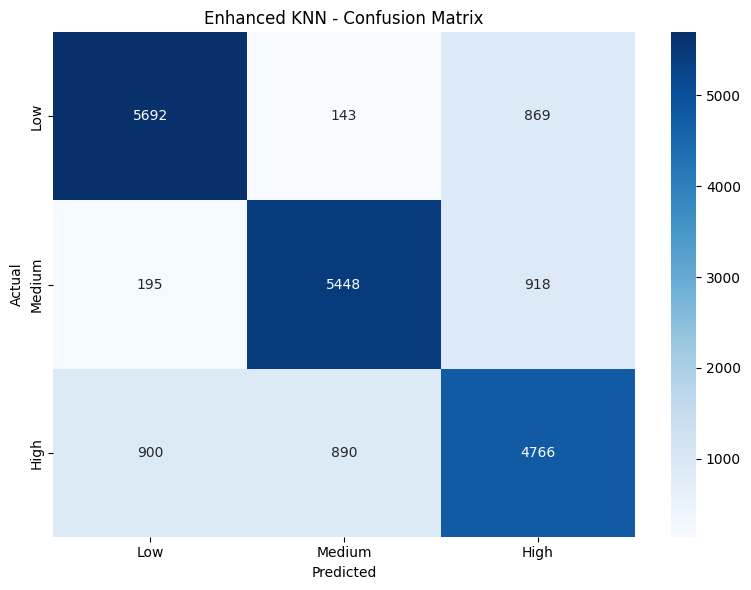

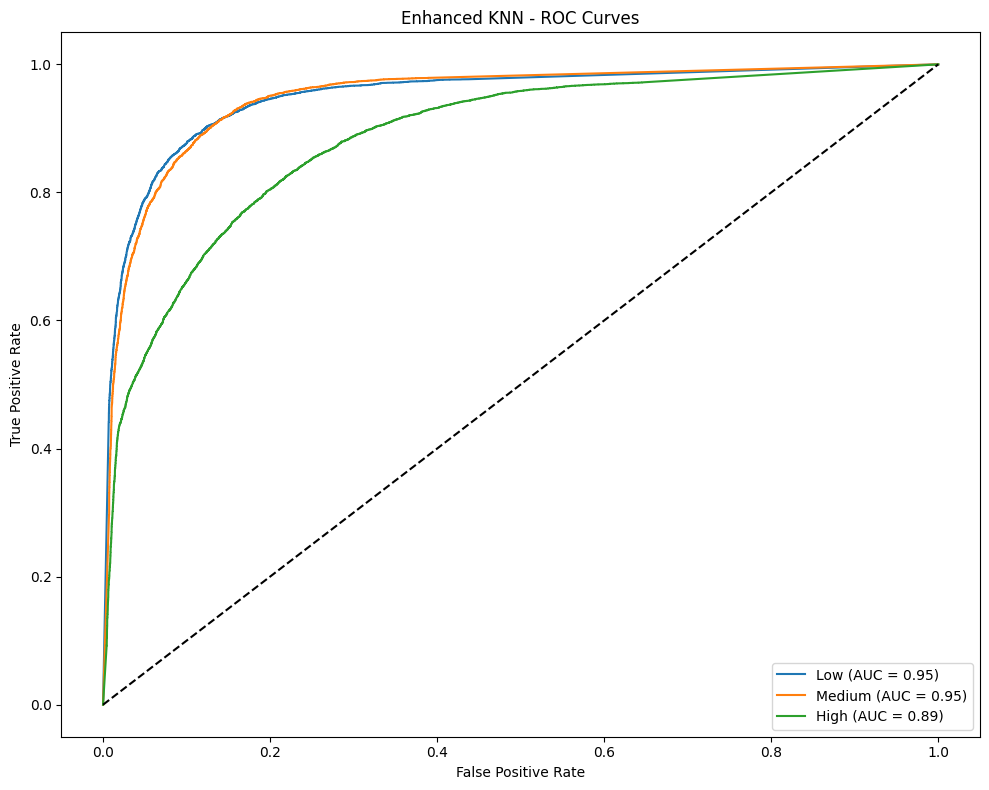

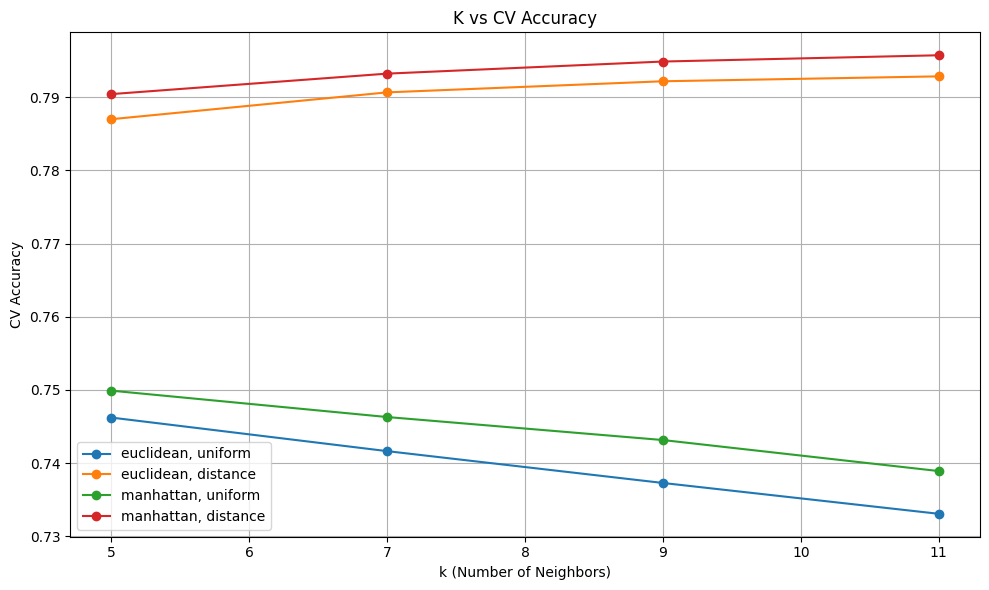

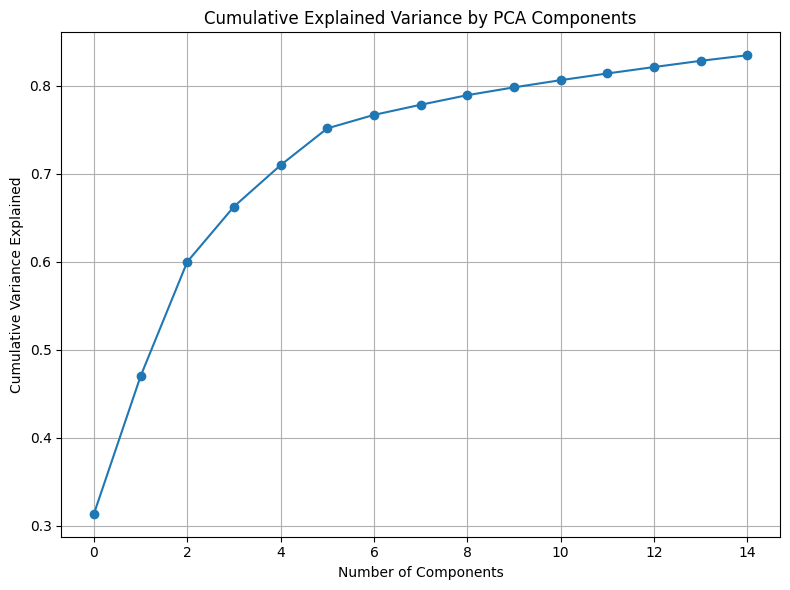

2025-04-23 22:02:46,747 - INFO - Model saved as enhanced_knn_model.joblib


In [8]:

if __name__ == "__main__":
    data = load_data(file_path)
    X, y, numeric_features, categorical_features, labels = preprocess_data(data)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    logger.info(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

    logger.info("Preprocessing and applying SMOTE...")
    X_train_processed = preprocessor.fit_transform(X_train)
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train_processed, y_train)
    logger.info(f"Resampled training set size: {X_resampled.shape}")

    pca = PCA(n_components=15)
    X_resampled_pca = pca.fit_transform(X_resampled)
    X_test_pca = pca.transform(preprocessor.transform(X_test))
    X_train_pca = pca.transform(preprocessor.transform(X_train))

    param_grid = {
        'n_neighbors': [5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    logger.info("Running GridSearchCV...")
    grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_resampled_pca, y_resampled)

    logger.info(f"Best Params: {grid.best_params_}")
    best_knn = grid.best_estimator_

    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', pca),
        ('classifier', best_knn)
    ])

    train_acc, test_acc = evaluate_model(final_pipeline, X_train, y_train, X_test, y_test, labels)
    plot_roc_curve(final_pipeline, X_test, y_test, labels)
    plot_k_vs_accuracy(grid)
    plot_pca_variance(pca)

    dump(final_pipeline, "enhanced_knn_model.joblib")
    logger.info("Model saved as enhanced_knn_model.joblib")
